# Задача:
Трансфероное обучение. Используя предобученные нейронные сети для задачи классификации изображений подобрать модель таким образом что бы метрики качества были максимальны. 
Вывести графики обучения. Проанализировать результат. Использовать келбеки для изменения скорости обучения и сохраннеия лучшей модели. Испаользовать набор данных с EuroSat
В ГИТ модель не пихать!

In [31]:
from keras import models
from keras import optimizers
from keras import layers
from keras.metrics import AUC
from matplotlib import pyplot as plt
import numpy as np
import tarfile
import os, shutil
import cv2

In [32]:
# fname = 'notMNIST_small.tar.gz'    # распаковываем данные
# if fname.endswith("tar.gz"):
#     tar = tarfile.open(fname, "r:gz")
#     tar.extractall()
#     tar.close()

In [33]:
base_dir = './EuroSAT'   # директорий для сохранения выделенного небольшого набора данных

In [34]:
os.listdir(f'{base_dir}/AnnualCrop')[:5]   # смотрим вид названия файлов

['AnnualCrop_1.jpg',
 'AnnualCrop_10.jpg',
 'AnnualCrop_100.jpg',
 'AnnualCrop_1000.jpg',
 'AnnualCrop_1001.jpg']

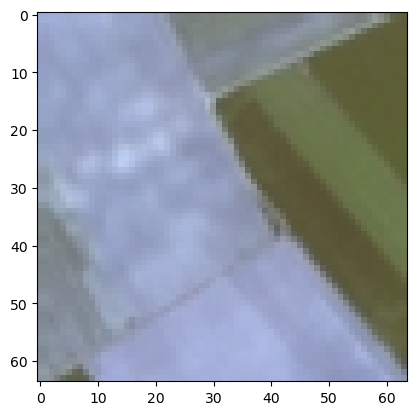

In [35]:
img = cv2.imread("./EuroSAT/AnnualCrop/AnnualCrop_1000.jpg")    # смотрим вид изображения
plt.imshow(img)
plt.show()

In [36]:
folders = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]  
for folder in folders:
  print(f"total {folder} images: {len(os.listdir(f'{base_dir}/{folder}'))}")    # смотрим количество данных каждого класса

total AnnualCrop images: 3000
total Forest images: 3000
total HerbaceousVegetation images: 3000
total Highway images: 2500
total Industrial images: 2500
total Pasture images: 2000
total PermanentCrop images: 2500
total Residential images: 3000
total River images: 2500
total SeaLake images: 3000


In [37]:
imgs = []
labels = []
for folder in folders:    
  for img in os.listdir(base_dir + f"/{folder}"):   
    if img.endswith('.jpg'):    
      try:    # если удалось прочитать 
        image = cv2.imread(base_dir + f"/{folder}/{img}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразуем BGR в RGB
        imgs.append(image)  # Добавляем изображение
        labels.append(folder)  # Добавляем метку класса            
      except:   # если возникла ошибка при чтении
        print(base_dir + f"/{folder}/{img}")     # выводим название изображение, которое не удалось прочитать
        continue
imgs = np.array(imgs).astype('float32')/255.    # масштабируем признаки

In [38]:
def to_categorical(labels):
 
  categories = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"] 
  new_labels = np.zeros(shape=(len(labels), len(categories)))
  for i, label in enumerate(labels):
        new_labels[i][categories.index(label)] = 1 
  return new_labels

AnnualCrop
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


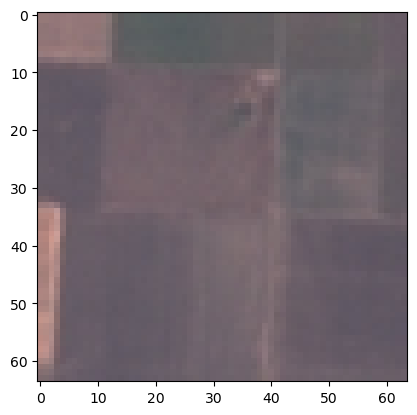

In [39]:
print(labels[0])    # выводим пример изображения с меткой
labels = to_categorical(labels)
plt.imshow(imgs[0])
print(labels[0])

In [40]:
indices = np.arange(labels.shape[0])    # перемешиваем данные
np.random.shuffle(indices)
imgs = imgs[indices]
labels = labels[indices]

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


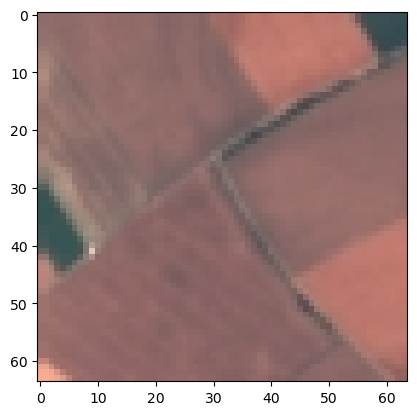

In [41]:
plt.imshow(imgs[0])
print(labels[0])

In [42]:
print("Images shape: ", imgs.shape)   # выводим размеры датасета
print("Labels shape: ", labels.shape)

Images shape:  (27000, 64, 64, 3)
Labels shape:  (27000, 10)


In [43]:
# разбиваем на тестовую и тренировочную выборку
X_test = imgs[:1500]
y_test = labels[:1500]
X_train = imgs[1500:]
y_train = labels[1500:]
print("Train images shape: ", X_train.shape)
print("Test images shape: ", X_test.shape)
print("Train labels shape: ", y_train.shape)
print("Test labels shape: ", y_test.shape)

Train images shape:  (25500, 64, 64, 3)
Test images shape:  (1500, 64, 64, 3)
Train labels shape:  (25500, 10)
Test labels shape:  (1500, 10)


In [44]:
# Добавим валидационную выборку
X_valid, X_train = X_train[:3000], X_train[3000:]
y_valid, y_train = y_train[:3000], y_train[3000:]
print("Train images shape: ", X_train.shape)
print("Valid images shape: ", X_valid.shape)
print("Train labels shape: ", y_train.shape)
print("Valid labels shape: ", y_valid.shape)

Train images shape:  (22500, 64, 64, 3)
Valid images shape:  (3000, 64, 64, 3)
Train labels shape:  (22500, 10)
Valid labels shape:  (3000, 10)


In [45]:
from transformers import TFViTForImageClassification, ViTImageProcessor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # Отключаем GPU (если используется)
tf.config.experimental_run_functions_eagerly(True)  # Включаем eager execution

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=10, ignore_mismatched_sizes=True)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
Some weights of TFViTForImageClassification were not initialized from the model checkpoint are newly initialize

In [47]:
# Предобработка изображений
from PIL import Image
def preprocess_image(image):
    image = Image.fromarray((image * 255).astype('uint8'))
    inputs = processor(images=image, return_tensors="tf")
    return inputs["pixel_values"][0]

X_train = np.array([preprocess_image(img) for img in X_train])
X_valid = np.array([preprocess_image(img) for img in X_valid])
X_test = np.array([preprocess_image(img) for img in X_test])

In [48]:
# Создание tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

In [49]:
import keras
from keras.callbacks import ReduceLROnPlateau
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/my_keras_model_{epoch}_{loss}.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

In [50]:
# Компиляция модели
model.compile(
    #optimizer=Adam(learning_rate=0.01),  
    loss=CategoricalCrossentropy(from_logits=True), 
    #metrics=[Accuracy()]  
)

In [57]:
# обучение модели

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    #callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/20



 77/704 [==>...........................] - ETA: 1:30:22 - loss: 2.3808

KeyboardInterrupt: 

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

In [ ]:
# Оценка модели
results = model.evaluate(test_dataset)
print(f"Test accuracy: {results[1] * 100:.2f}%")